# Safe-Borderline GANs

## Evaluating the quality of generated class-specific data


From:

L. Akritidis, A. Fevgas, M. Alamaniotis, P. Bozanis, "Conditional Data Synthesis with Deep Generative Models for Imbalanced Dataset Oversampling", In Proceedings of the 35th IEEE International Conference on Tools with Artificial Intelligence (ICTAI), to appear, 2023.

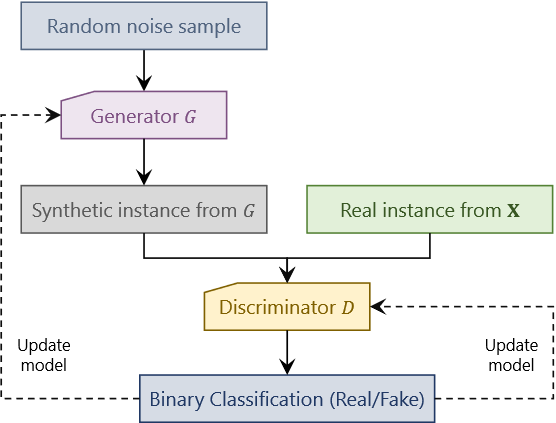


Generative Adversarial Nets (GANs) are among the leading architectures in the area of generative modeling. Inside a GAN, two Neural Networks compete each other with the aim of learning the target distribution and generating artificial
data: a Discriminator $D$ and a Generator $G$.

The Discriminator $D$ is a binary classifier trained to distinguish whether its input data samples are real or not. For this reason, $D$ trained with both real and fake examples. The real examples are drawn from the original training set $\mathbf{X}$, whereas the fake ones are synthesized by the Generator $G$. Its loss function penalizes all misclassifications, namely, real data identified as fake, or fake data identified as real. At each iteration, $D$ updates its parameters using backpropagation, thus improving its ability to identify fake data instances.

The Generator $G$ learns to synthesize artificial data instances by using the output of $D$. Its goal is to deceive the discriminator $D$, so that its output is classified as real. The training of $G$ takes place simultaneously with that of $D$ and involves the following phases: Initially, a random noise sample is used it to produce the output of $G$. The output of $G$ is fed to $D$ and the discriminator loss is computed. The error is then backpropagated to compute the necessary gradients and update only the weights of $G$.

Formally, $D$ and $G$ play the following zero-sum game:

$$\min_G\max_D V(D,G)=\mathbb{E}_{\mathbf{x}\sim p_{\mathbf{x}}(\mathbf{x})}[\log(D(\mathbf{x}))]+
\mathbb{E}_{\mathbf{z}\sim p_{z}(\mathbf{z})}[\log(1-D(G(\mathbf{z})))]$$


In many cases, the objective is not to simply generate artificial data, but to synthesize data instances belonging to a particular class. Conditional GANs (CGANs) address this requirement by receiving as inputs both the samples and their respective classes $\mathbf{y}$ \cite{arxiv2014}. This applies to both Discriminator and Generator, so the aforementioned zero-sum game becomes: 

$$\min_G\max_D V(D,G)=\mathbb{E}_{\mathbf{x}\sim p_{\mathbf{x}}(\mathbf{x}|)}[\log(D(\mathbf{x}|\mathbf{y}))]+
\mathbb{E}_{\mathbf{z}\sim p_{z}(\mathbf{z})}[\log(1-D(G(\mathbf{z}|\mathbf{y})))]$$

During CGAN training, the one-hot-encoded vectors $\mathbf{y}$ are fed to both the Discriminator and the Generator, after they have been concatenated with the input feature vectors (either fake, or real ones).


In [3]:
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

import DeepCoreML.DataTools
from DeepCoreML.GANs.SBGAN import sbGAN
from DeepCoreML.DataAnimator import DataAnimator

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

seed = 111
DeepCoreML.DataTools.set_random_states(seed)


## Data

The following code produces a random dataset of `num_samples` samples classified into `num_classes` classes. The dataset is intentinally imbalanced; each class comprises different numbers of samples. The imbalance ratio is controlled by the `class_weights` array.


In [ ]:
num_samples = 1000
class_weights = [0.50, 0.30, 0.1, 0.1 ]
num_classes = len(class_weights)

data = make_classification(n_samples=num_samples, n_features=2, n_clusters_per_class=1,
                              n_classes=num_classes, weights=class_weights, flip_y=0, class_sep=1.0,
                              n_informative=2, n_redundant=0, n_repeated=0, random_state=seed)
x_data = data[0]
y_data = data[1]

min_x = x_data[:,0].min()
max_x = x_data[:,0].max()
min_y = x_data[:,1].min()
max_y = x_data[:,1].max()

fig = plt.figure(figsize=(6, 4))

ax=fig.add_subplot(111)
ax.clear()
ax.grid(True)
ax.set_xlim(1.1 * min_x, 1.1 * max_x)
ax.set_ylim(1.1 * min_y, 1.1 * max_y)

for c in range(num_classes):
    hcor = [x[0] for n, x in enumerate(x_data) if y_data[n] == c]
    vcor = [x[1] for n, x in enumerate(x_data) if y_data[n] == c]
    ax.plot(hcor, vcor, 'o')

plt.show()


## Discriminator

The `Discriminator` $D$ is implemented as a typical fully connected network. The architecture of $D$ and the dimensionality of the input data are passed as paramaters to the constructor of the class. We select the Leaky Rectified Linear Unit as the activation function of all neurons in each layer. Each layer of the network is followed by a `Dropout` layer.

A typical GAN discriminator is a binary classifier that produces 0/1 (real/fake) outputs. Thus, there is only a single neuron in the output layer and its activation function is the Logistic `Sigmoid` function.


## Packed Discriminator

A packed Discriminator accepts multiple inputs at once. In \[\] the authors proved that feeding the Discriminator with multiple input vectors with the same label limits the problem of mode collapse in GANs. The Generator architecture remains the same. This GAN is known as PacGAN

The packed Discriminator is implemented on the basis of the original Discriminator, but we also pass a `pac` argument and the input dime


## Generator

The `Generator` $G$ is also a fully connected network comprised of a stack of residual blocks. Its architecture passes as an argument to the constructor of the class. The dimensionality of `Generator`'s input is the dimensionality of the latent (noise) samples. Its output dimensionality is the dimensionality of the real input data.

Similarly to $D$, we select the Leaky Rectified Linear Unit as the activation function of all neurons in each layer. `Dropout` is not applied here. In this particular example, batch normalization has a destructive impact on the performance of $G$.


## Conditional GAN

Conditional GANs (cGANs) can conditionally generate data given a class. In a typical setting, a user requests from a cGAN to generate samples belonging to a particular class and the network outputs samples matching this request.

cGANs are trained by providing not only the sample vectors, but also the class labels. In a typical implementation like the following one, the class labels are initially one-hot-encoded; then, the one-hot-encoded class representation is concatenated with the feature vectors and fed to both the Discriminator and the Generator.


## PacGAN architecture & Training params

In [ ]:
DISCRIMINATOR = (128, 64, 32)
GENERATOR = (32, 32)

NUM_EPOCHS = 100
BATCH_SIZE = 32


## PacGAN Training

In [ ]:
clf = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, max_features='sqrt', random_state=seed)

sbgan = sbGAN(discriminator=DISCRIMINATOR, generator=GENERATOR, pac=1, method='knn' k=5, random_state=seed)

# c_gan.train(x_data, y_data, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, loss_function=nn.BCELoss())

synthetic_data, mean_costs = sbgan.adaptive_train(x_data, y_data, clf, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)


## IcGAN/Incremental cGAN

Notation:

|                | Real Data       | Latent Data    | Generated Data  |
|--              | ---             | ---            | ---             |
| Vector         | $\mathbf{x}_r$  | $\mathbf{x}_l$ | $\mathbf{x}_g$  |
| Classes        | $\mathbf{y}_r$  | $\mathbf{y}_l$ | $\mathbf{y}_g$  |
| Data           | ---           | ---         | -            |
| Labels         | ---           | ---         | -            |

Training Process:

1. for epoch $e$
2.    for batch $b$ of size $s_b$
3. $\mathbf{x}_l \leftarrow$ randomly take $s_b$ latent samples from a standard distribution.
4. $\mathbf{y}_l \leftarrow$ randomly take $s_b$ class samples from a uniform distribution in $[0,|C|]$ and encode them with one-hot-encoding.
5. Concatenate vectors with one-hot-encoded classes $\mathbf{d}_l \leftarrow [\mathbf{x}_l~~~\mathbf{y}_l]$
6. Generate data $\mathbf{x}_g \leftarrow \mathcal{G}(\mathbf{d}_l)$, $\mathbf{y}_g \leftarrow \mathbf{y}_l$.
7. Concatenate the generated data with the real ones: $\mathbf{x} \leftarrow [ \mathbf{x}_r~~~\mathbf{x}_g ]$, $\mathbf{y} \leftarrow [ \mathbf{y}_r~~~\mathbf{y}_g ]$, 
8. Pass the concatenated data to the Discriminator and get the predictions: $\hat{\mathcal{l}} \leftarrow \mathcal{D}(\mathbf{x})$

8. $loss_{\mathcal{D}} \leftarrow BCE(\hat{\mathcal{l}}, )$


In [ ]:
%matplotlib nbagg

Animator = DataAnimator(synthetic_data, num_classes, "../vizualizations/PacCGAN.gif")
Animator.animate_data(NUM_EPOCHS, min_x, max_x, min_y, max_y)

In [ ]:
fig_final = plt.figure()

ax_final = fig_final.add_subplot(111)
ax_final.clear()
ax_final.grid(True)
ax_final.set_xlim(1.1 * min_x, 1.1 * max_x)
ax_final.set_ylim(1.1 * min_y, 1.1 * max_y)
ax_final.set_title(str(NUM_EPOCHS) + " epochs")
ax_final.set_xlabel("x1")
ax_final.set_ylabel("x2")

for c in range(num_classes):
    ax_final.plot(synthetic_data[NUM_EPOCHS-1][c][:, 0], synthetic_data[NUM_EPOCHS-1][c][:, 1], 'o')

plt.show()


## Interesting snapshots

In [ ]:
plot_columns = 2
plot_rows = math.ceil((5 + ((NUM_EPOCHS - 50) / 50)) / plot_columns)
height = plot_rows * 4


def plot_snapshot(epoch, pos, fig):
    ax_s = fig.add_subplot(plot_rows, 2, pos)
    ax_s.grid(True)
    ax_s.set_xlim(min_x, max_x)
    ax_s.set_ylim(min_y, max_y)
    ax_s.set_title(str(epoch+1) + " epochs")

    for c in range(num_classes):
        ax_s.plot(synthetic_data[epoch][c][:, 0], synthetic_data[epoch][c][:, 1], 'o')

    plt.show()

mfig = plt.figure(figsize=(10, height))


plot_snapshot(9, 1, mfig)
plot_snapshot(19, 2, mfig)
plot_snapshot(29, 3, mfig)
plot_snapshot(39, 4, mfig)
plot_snapshot(49, 5, mfig)

if NUM_EPOCHS > 99:
    plot_snapshot(99, 6, mfig)
if NUM_EPOCHS > 149:
    plot_snapshot(149, 7, mfig)
if NUM_EPOCHS > 199:
    plot_snapshot(199, 8, mfig)
if NUM_EPOCHS > 249:
    plot_snapshot(249, 9, mfig)
